# Breast Cancer Tumor Classification: Predicting Malignancy 
## Data
UCI Breast Cancer Wisconsin dataset

Source: https://archive.ics.uci.edu/dataset/15/breast+cancer+wisconsin+original
## Problem Introduction
This project aims to predict whether a tumor is *Benign* or *Malignant* based on the features, using interpretable machine learning methods.

## Motivation
Early, reliable detection of malignant tumors is crucial for effective intervention. Automated, explainable predictions can assist radiologists and reduce diagnostic errors, offering critical support in clinical workflows.

## Project Overview
- Data Source: UCI Breast Cancer Wisconsin Dataset
- Problem Type: Binary Classification
- Target Variable: Tumor Class ('Benign' or 'Malignant')

## Summary of Analysis
- Cleaned and imputed missing values (class-wise medians).
- Conducted exploratory data analysis (EDA) with boxplots and correlation heatmaps.
- Identified top predictive features using Mutual Information and Permutation Importance.
- Built and tuned a Logistic Regression model with L1 regularization.
- Achieved outstanding performance (AUC ≈ 0.995) and explained predictions through feature importance analysis.

## Key Findings
- *Bare Nuclei*, *Clump Thickness*, and *Bland Chromatin* are the most critical features.
- Removing less important features (e.g., *Marginal Adhesion*) did not significantly change model performance.
- The model is highly accurate, well-calibrated, and interpretable, suitable for clinical decision support.


### Step 1: Import Libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Step 2: Read Data
Load the breast cancer dataset, assign column names, treat '?' as NaN, and map labels to 'Benign'/'Malignant'.

In [2]:
# Define column names (from the .names file)
cols = [
    "ID",
    "Clump Thickness",
    "Uniformity of Cell Size",
    "Uniformity of Cell Shape",
    "Marginal Adhesion",
    "Single Epithelial Cell Size",
    "Bare Nuclei",
    "Bland Chromatin",
    "Normal Nucleoli",
    "Mitoses",
    "Class"
]

# Read the data, treating '?' as NaN
df = pd.read_csv(
    "breast-cancer-wisconsin.data",  # or the relative path to your file
    header=None,
    names=cols,
    na_values="?"
)

# Map the Class labels to something more readable
df["Class"] = df["Class"].map({2: "Benign", 4: "Malignant"})

df.head()

,ID,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1.0,3,1,1,Benign
1,1002945,5,4,4,5,7,10.0,3,2,1,Benign
2,1015425,3,1,1,1,2,2.0,3,1,1,Benign
3,1016277,6,8,8,1,3,4.0,3,7,1,Benign
4,1017023,4,1,1,3,2,1.0,3,1,1,Benign


### Step 3: Exploratory Data Analysis

Display summary statistics for each feature to understand data spread.

In [3]:
df.describe()

,ID,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses
count,6.990000e+02,699.000000,699.000000,699.000000,699.000000,699.000000,683.000000,699.000000,699.000000,699.000000
mean,1.071704e+06,4.417740,3.134478,3.207439,2.806867,3.216023,3.544656,3.437768,2.866953,1.589413
std,6.170957e+05,2.815741,3.051459,2.971913,2.855379,2.214300,3.643857,2.438364,3.053634,1.715078
min,6.163400e+04,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,8.706885e+05,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000
50%,1.171710e+06,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000
75%,1.238298e+06,6.000000,5.000000,5.000000,4.000000,4.000000,6.000000,5.000000,4.000000,1.000000
max,1.345435e+07,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


Check dataset shape and missing values in each feature.

In [4]:
print(df.shape)
print(df.isna().sum())

(699, 11)
ID                              0
Clump Thickness                 0
Uniformity of Cell Size         0
Uniformity of Cell Shape        0
Marginal Adhesion               0
Single Epithelial Cell Size     0
Bare Nuclei                    16
Bland Chromatin                 0
Normal Nucleoli                 0
Mitoses                         0
Class                           0
dtype: int64


##### - 16 rows are missing values in the Bare Nuclei column, marked as NaN.

#### Distribution of Bare Nuclei by Tumor class:

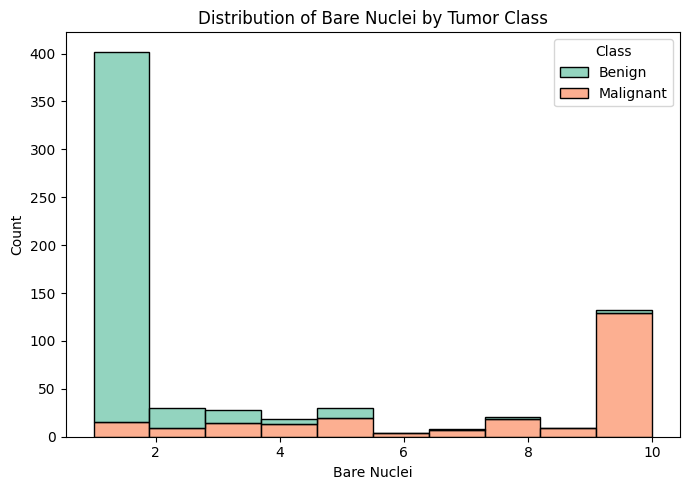

In [5]:
plt.figure(figsize=(7, 5))
sns.histplot(data=df, x='Bare Nuclei', hue='Class', multiple='stack', bins=10, palette='Set2', alpha=0.7)
plt.title('Distribution of Bare Nuclei by Tumor Class')
plt.xlabel('Bare Nuclei')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

#### Inspecting Bare Nuclei to Guide Imputation

- Bare Nuclei has skewed distribution.

- Both classes show clear differences in distribution, so this feature is highly informative.

#### Findings

I found that the Bare Nuclei feature had missing values. Since the distribution of this feature is different for benign and malignant tumors, I used class-wise median imputation, filling in the missing values with the median of each class separately. This helps preserve the original patterns in the data and avoids biasing the model.

### Step 4: Handle Missing Values

In [6]:
df_imputed = df.copy()

# Calculate the median of 'Bare Nuclei' separately for each class
class_medians = df_imputed.groupby('Class')['Bare Nuclei'].median()

# Apply imputation — for each row with a missing value, fill it using the class-specific median
df_imputed['Bare Nuclei'] = df_imputed.apply(
    lambda row: class_medians[row['Class']] if pd.isna(row['Bare Nuclei']) else row['Bare Nuclei'],
    axis=1)

print("Missing values after imputation:\n", df_imputed.isna().sum())

Missing values after imputation:
 ID                             0
Clump Thickness                0
Uniformity of Cell Size        0
Uniformity of Cell Shape       0
Marginal Adhesion              0
Single Epithelial Cell Size    0
Bare Nuclei                    0
Bland Chromatin                0
Normal Nucleoli                0
Mitoses                        0
Class                          0
dtype: int64


I checked the distribution of Bare Nuclei column before and after immputation. 

The distributions look similar, which shows that the class-wise median imputation method preserved the original shape of the data.

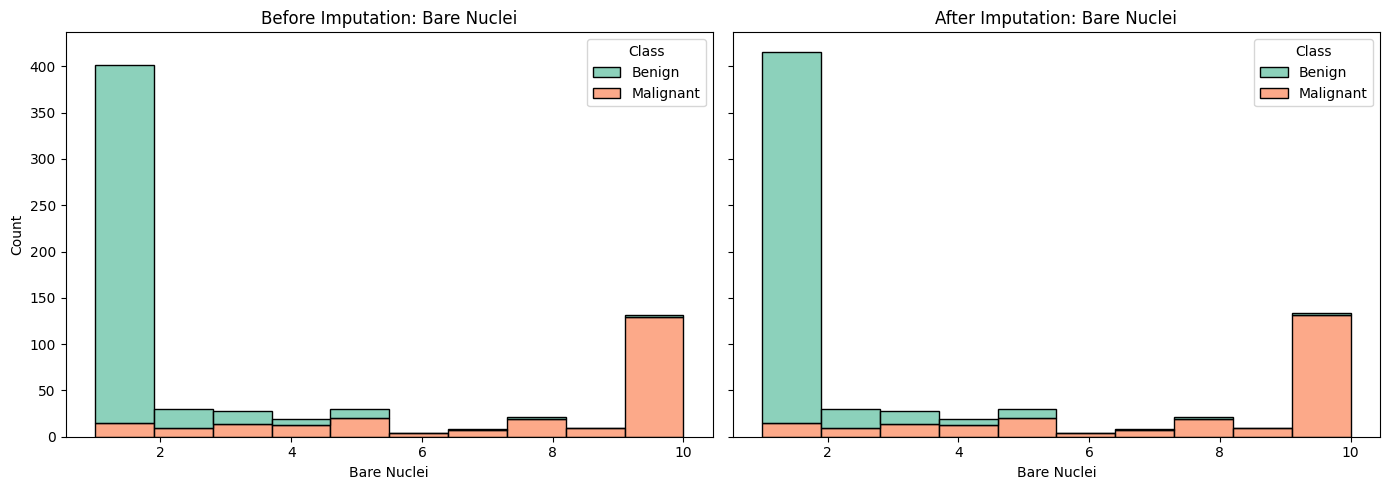

In [7]:
df_before = df.copy()
df_after = df_imputed.copy()


fig, axes = plt.subplots(ncols=2, figsize=(14, 5), sharey=True)

# Before imputation
sns.histplot(data=df_before, x='Bare Nuclei', hue='Class', multiple='stack', bins=10, palette='Set2', ax=axes[0])
axes[0].set_title('Before Imputation: Bare Nuclei')
axes[0].set_xlabel('Bare Nuclei')
axes[0].set_ylabel('Count')

# After imputation
sns.histplot(data=df_after, x='Bare Nuclei', hue='Class', multiple='stack', bins=10, palette='Set2', ax=axes[1])
axes[1].set_title('After Imputation: Bare Nuclei')
axes[1].set_xlabel('Bare Nuclei')

plt.tight_layout()
plt.show()


### Step 5: Visualize class distribution to check balance between 'Benign' and 'Malignant'.

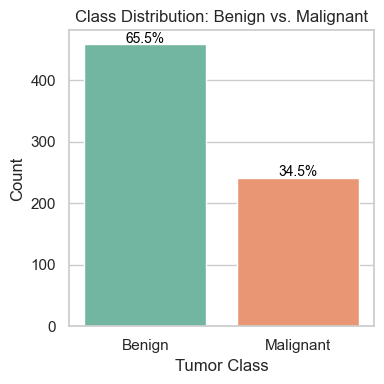

In [8]:
df_eda = df_imputed.drop(columns=['ID'])


sns.set(style="whitegrid")


plt.figure(figsize=(4, 4))
ax = sns.countplot(x='Class', data=df_eda, palette='Set2', hue='Class')
total = len(df_eda)
for p in ax.patches:
    percentage = 100 * p.get_height() / total
    ax.annotate(f'{percentage:.1f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                fontsize=10, color='black', 
                xytext=(0, 4), 
                textcoords='offset points')


plt.title('Class Distribution: Benign vs. Malignant')
plt.xlabel('Tumor Class')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

#### Findings - Class Distribution
- The dataset contains more Benign (65%) than Malignant (35%) cases.

- To help the model handle this imbalance and prevent overfitting, I used regularization (L1 penalty) in logistic regression. Regularization improves the model’s generalization and reduces the impact of noise.

### Question: How helpful is each feature in predicting whether a tumor is benign or malignant?

### Step 6: Feature Importance
#### 1. Features' distributions:
compare distribution of each feature between classes using boxplots.

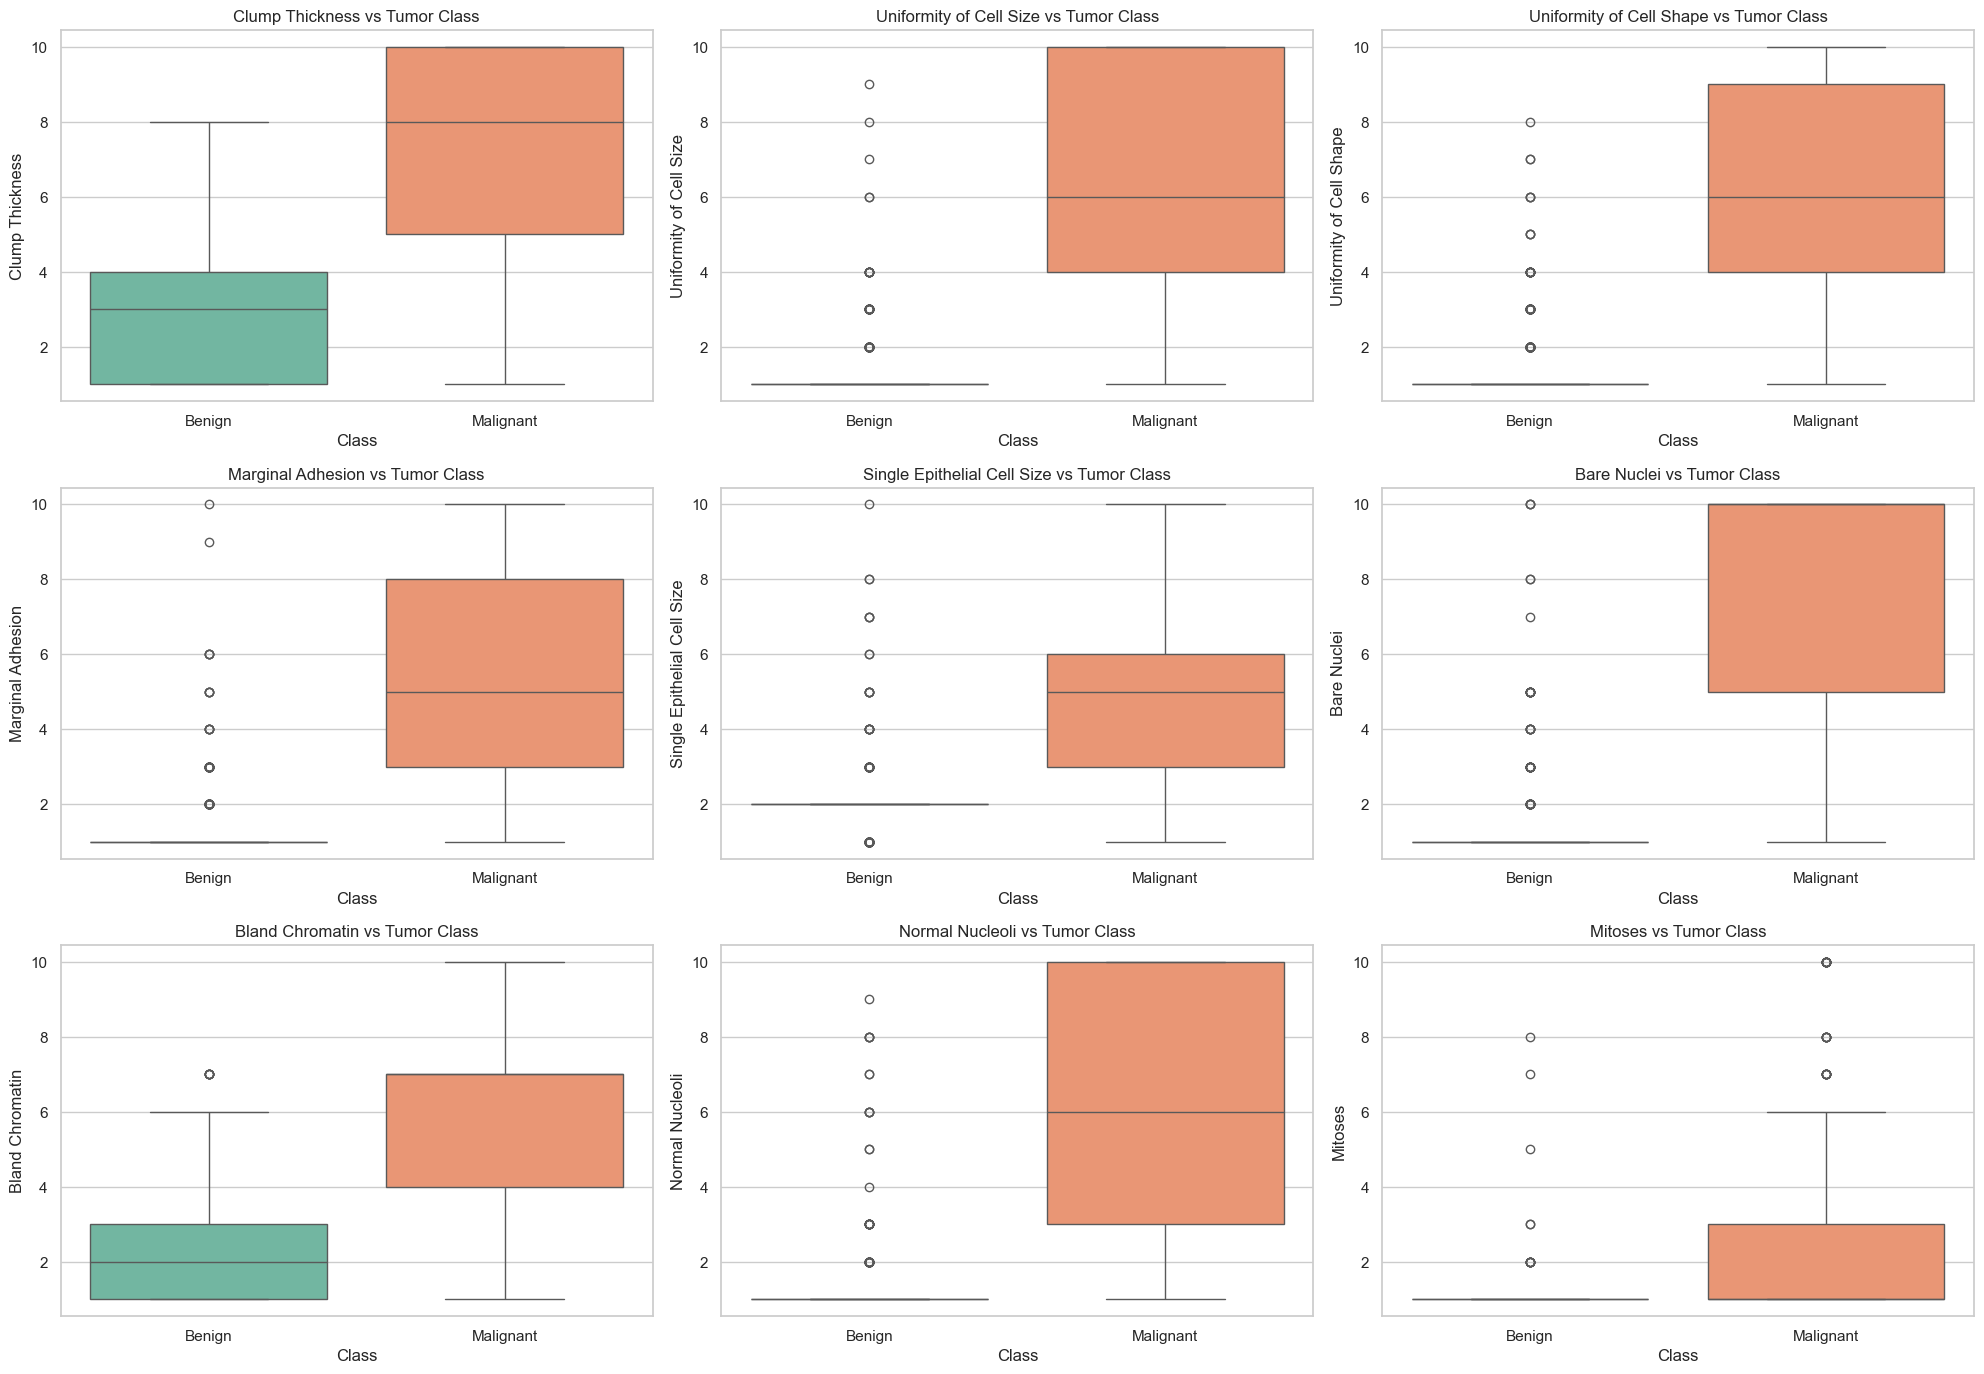

In [9]:
# Create boxplots for each feature by class
feature_cols = df_eda.columns[:-1]  # exclude 'Class'

plt.figure(figsize=(20, 18))
for i, col in enumerate(feature_cols, 1):
    plt.subplot(4, 3, i)
    sns.boxplot(x='Class', y=col, data=df_eda, palette='Set2', hue='Class')
    plt.title(f'{col} vs Tumor Class')
    plt.tight_layout()
plt.show()

#### 2. Mutual Information:
- Mutual Information tells me how much a feature helps reduce our uncertainty about the tumor class. The more it helps, the more important the feature is.


So I rank features based on mutual information with the target (class).

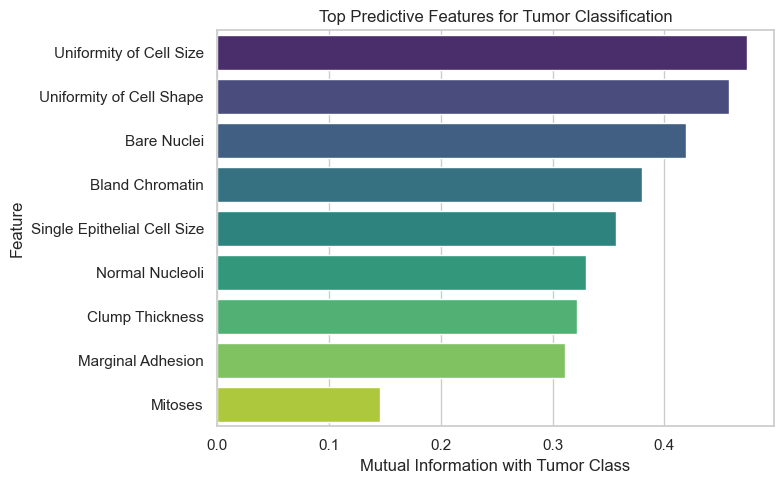

In [10]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder


X = df_eda.drop(columns='Class')
y = LabelEncoder().fit_transform(df_eda['Class'])  # Malignant=1, Benign=0


mi_scores = mutual_info_classif(X, y, discrete_features=True)


mi_df = (pd.DataFrame({'Feature': X.columns, 'Mutual Information': mi_scores}).sort_values('Mutual Information', ascending=False))


plt.figure(figsize=(8, 5))
sns.barplot(data=mi_df, x='Mutual Information', y='Feature', palette='viridis', hue='Feature')
plt.title('Top Predictive Features for Tumor Classification')
plt.xlabel('Mutual Information with Tumor Class')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

#### Findings: 

- I found that the features such as Bare Nuclei and Uniformity of Cell Size and shape, show significant differences between benign and malignant tumors.
- These features each have an MI score above 0.4, which means they significantly reduce uncertainty about the tumor class when included in the model.
- They are important contributors to the model and I should consider them in the modeling.

#### 3. Correlation Analysis
Compute feature correlation matrix to detect feature relationships.

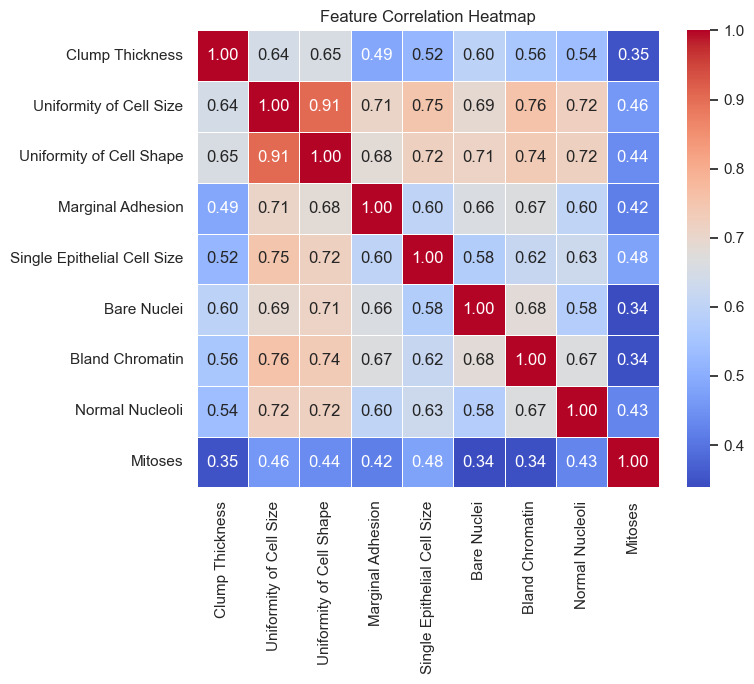

In [11]:
X_corr = df_eda.drop(columns="Class")
corr_matrix = X_corr.corr()

plt.figure(figsize=(8, 7))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()

#### 4. Variance Inflation Factor (VIF) 
Calculate VIF to check multicollinearity among features.

In [12]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Prepare X for VIF calculation
X_vif = df_eda.drop(columns="Class")
X_vif_const = add_constant(X_vif)  # Add constant for VIF function

vif_data = pd.DataFrame()
vif_data["Feature"] = X_vif_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif_const.values, i) for i in range(X_vif_const.shape[1])]

vif_data.sort_values("VIF", ascending=False)

,Feature,VIF
2,Uniformity of Cell Size,7.189270
3,Uniformity of Cell Shape,6.512232
0,const,5.082203
7,Bland Chromatin,2.884335
6,Bare Nuclei,2.560248
5,Single Epithelial Cell Size,2.539758
8,Normal Nucleoli,2.440441
4,Marginal Adhesion,2.430854
1,Clump Thickness,1.920066
9,Mitoses,1.388796


#### Findings:
- Several top features are highly correlated with each other: Uniformity of Cell Size and Uniformity of Cell Shape: correlation = 0.91
- Bland Chromatin, Single Epithelial Cell Size, and others also show moderate-to-high correlations.
- VIF confirms that Uniformity of Cell Size and Shape have higher multicollinearity (VIF > 5)


***Based on this analysis, I observed that some features such as Uniformity of Cell Size and Shape carry overlapping signals due to their high correlation and VIF values. However, since the total number of features in this dataset is small, and I’m using L1-regularized logistic regression, it is reasonable to keep all features in the model.

L1 regularization (Lasso) helps by automatically shrinking the impact of less useful or redundant features, letting the model focus on the most predictive ones while still being simple and interpretable.

### Step 7: Training a Logistic Regression model
I chose logistic regression for this project because it is perfectly suited to a binary-classification task like distinguishing malignant from benign tumors. Logistic regression delivers probability estimates for each class and, unlike many black-box models, provides transparent coefficients that can be translated into odds ratios, an essential requirement when working with medical diagnoses, where clinicians need to understand why a model flags a case as high-risk. 
L1 regularisation further helps by automatically down-weighting redundant features while keeping the model simple. Although I normally use several predictive modelings and compare their performances, logistic regression already meets both the interpretability and high-performance goals for this dataset, so adding more complex models was unnecessary here.

In [13]:
X = df_eda.iloc[:, 0:-1].values
y = df_eda.iloc[:, -1].values
y = pd.Series(y).map({'Benign': 0, 'Malignant': 1}).values

#### Splitting the dataset into the Training set and Test set
Split data into training and testing sets (stratified by class).

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

#### I ran a grid search to find the best regularization settings for the logistic-regression model.

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Define grid: regularization strength (C) and type (penalty)
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']  # liblinear supports both l1 and l2
}


grid_search = GridSearchCV(
    LogisticRegression(random_state=0, max_iter=1000),
    param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1
)


grid_search.fit(X_train, y_train)

# Best model and score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best CV ROC-AUC Score:", grid_search.best_score_)


Best Hyperparameters: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Best CV ROC-AUC Score: 0.9939829302987198


#### Training the Logistic Regression model on the Training set

Train a Logistic Regression model (with regularization).

In [16]:
classifier = LogisticRegression(penalty="l1", solver="liblinear",random_state = 0)
classifier.fit(X_train, y_train)

LogisticRegression(penalty='l1', random_state=0, solver='liblinear')

### Step 8: Predicting the Test set results


In [17]:
y_pred = classifier.predict(X_test)

### Step 9: Model Evaluation
Evaluate model performance (precision, recall, F1, confusion matrix).

In [18]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[82  3]
 [ 1 54]]


In [26]:
y_prob = classifier.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_prob)
print(f"AUC with all features: {auc:.4f}")

AUC with all features: 0.9951


In [19]:
from sklearn.metrics import precision_score, recall_score, f1_score
precision_val = precision_score(y_test, y_pred)
recall_val = recall_score(y_test, y_pred)
f1_val = f1_score(y_test, y_pred)

precision_val, recall_val, f1_val

(0.9473684210526315, 0.9818181818181818, 0.9642857142857143)

#### Findings:

The model is highly accurate:

- Precision 0.95 means that about 95 % of tumors it labels malignant really are malignant,

- Recall 0.98 means it catches almost 98 % of all malignant tumors,

- resulting in an overall F1-score of 0.96, showing a strong balance between precision and recall.

#### Computing the accuracy with k-Fold Cross Validation

In [20]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 5)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Accuracy: 96.78 %
Standard Deviation: 2.00 %


The 5-fold cross-validation shows that the model has a high average accuracy of 96.78%, with a small standard deviation of 2%, meaning the model performs consistently well across different data splits.

### Step 10: Extracting and Interpreting Logistic Regression Coefficients

**Question: Which features are the strongest indicators of malignancy?**


In [21]:
feature_names = df_eda.columns[:-1].tolist()


coefs = classifier.coef_[0]

coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefs,
    'Odds Ratio': np.exp(coefs)
})


coef_df = coef_df[np.abs(coef_df['Coefficient']) > 1e-4]


coef_df = coef_df.sort_values(by='Odds Ratio', ascending=False).reset_index(drop=True)


print(coef_df.to_string(index=False))

                    Feature  Coefficient  Odds Ratio
            Clump Thickness     0.450700    1.569410
                Bare Nuclei     0.398525    1.489627
                    Mitoses     0.359739    1.432955
          Marginal Adhesion     0.325790    1.385125
   Uniformity of Cell Shape     0.272106    1.312726
            Bland Chromatin     0.266277    1.305097
            Normal Nucleoli     0.154714    1.167325
Single Epithelial Cell Size     0.116579    1.123646
    Uniformity of Cell Size     0.025961    1.026301


Key Findings from the Table

- Clump Thickness has the strongest effect.
A one-unit increase multiplies the odds of malignancy by 1.57 times (57% higher odds).

- Bare Nuclei is also very important, increasing odds by about 49% per unit increase.

- Mitoses and Marginal Adhesion moderately increase the odds by 43% and 38%, respectively.

- Features like Uniformity of Cell Shape, Bland Chromatin, and Normal Nucleoli also contribute positively but with smaller impacts.

- Uniformity of Cell Size has a very small coefficient and odds ratio close to 1, meaning it has a weak effect after accounting for other features.

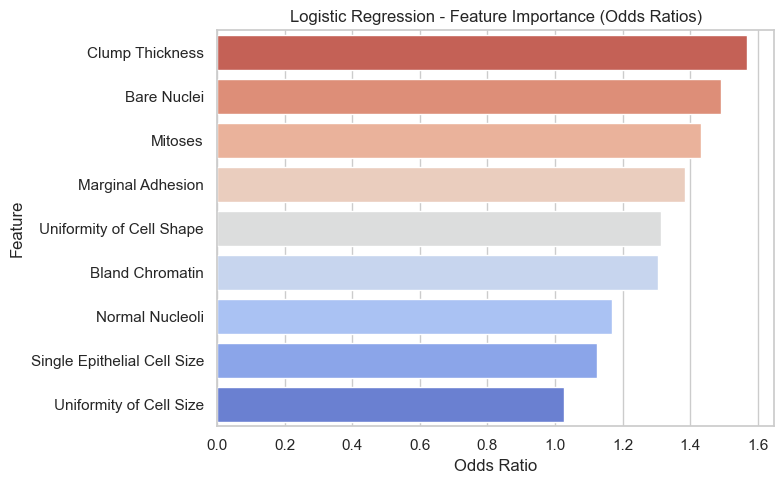

In [22]:
plt.figure(figsize=(8, 5))
sns.barplot(data=coef_df, x='Odds Ratio', y='Feature', palette='coolwarm_r', hue='Feature')
plt.title('Logistic Regression - Feature Importance (Odds Ratios)')
plt.tight_layout()
plt.show()


#### Findings:
Higher values in Clump Thickness, Bare Nuclei, and Mitoses are strong warning signs for malignancy, while other features also help but to a smaller extent.

### Step 11: Measuring How Each Feature Impacts Model Performance Using Permutation Importance
**Question: What about overall importance to model performance?**

I used permutation importance to measure how much each feature actually affects the model’s performance. By randomly shuffling one feature at a time and checking how much the model’s accuracy drops, I can see which features the model truly relies on. This method helps confirm which features are the most important in practice, not just in theory.

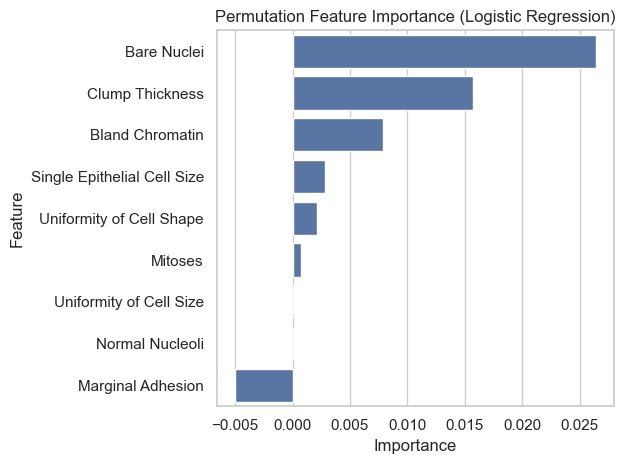

In [23]:
from sklearn.inspection import permutation_importance

result = permutation_importance(classifier, X_test, y_test, n_repeats=10, random_state=42)

perm_df = pd.DataFrame({
    'Feature': df_eda.columns[:-1],
    'Importance': result.importances_mean
}).sort_values(by='Importance', ascending=False)

sns.barplot(data=perm_df, x='Importance', y='Feature')
plt.title('Permutation Feature Importance (Logistic Regression)')
plt.tight_layout()
plt.show()


- Bare Nuclei is the most important feature, shuffling it causes the model's performance to drop the most, meaning the model heavily relies on it to predict tumor class.

- Clump Thickness and Bland Chromatin also contribute significantly to the model's decisions.

- Features like Single Epithelial Cell Size, Uniformity of Cell Shape, and Mitoses have only a small impact.

- Interestingly, Marginal Adhesion has a slightly negative importance, meaning that shuffling it sometimes improves the model — possibly because its signal overlaps with stronger features or introduces noise.


- Uniformity of Cell Size and Normal Nucleoli appear to have minimal effect, despite being statistically associated with tumor class (as seen earlier in mutual information).


### Question: Why Odds Ratio and Permutation Importance Give Different Results?

1. Odds Ratio (from Logistic Regression)
- Measures how much the odds of malignancy change when a feature increases by one unit, assuming all other features stay the same.

- It reflects the direction and strength of association between a feature and the outcome.

- For example, Marginal Adhesion had an odds ratio > 1, meaning it’s positively associated with malignancy, if all other features are fixed.

2.Permutation Importance
- Measures how much the model’s overall performance drops when the values of a feature are shuffled.

- It captures how essential the feature is to prediction, given the presence of all others.

- Example: In this case, shuffling Marginal Adhesion caused little to no performance drop (or even improved it slightly), suggesting that other features already carry similar information, making this one redundant in practice.

***Final Clarification:

Odds ratios tell us how a feature individually affects the model’s prediction, while permutation importance tells us how much the model relies on that feature when making decisions.
So, a feature can have a high odds ratio but low permutation importance if its information is already captured by stronger, overlapping features.

### Step 12: Evaluating Model Impact by Removing a Feature
Motivation:
The permutation importance analysis showed that Marginal Adhesion has a negative importance score, meaning the model might actually perform better without it. This suggests that the feature is likely redundant, and other features already provide similar information.

To test this, I removed Marginal Adhesion from the dataset, retrained the model, and compared its performance (AUC) to the original model. This helps confirm whether excluding this feature simplifies the model without reducing predictive power.

In [24]:

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# Get column index of "Marginal Adhesion"
import numpy as np
import pandas as pd

feature_names = df_eda.columns[:-1].tolist()  # all features except 'Class'
ma_index = feature_names.index("Marginal Adhesion")


X_train_no_MA = np.delete(X_train, ma_index, axis=1)
X_test_no_MA = np.delete(X_test, ma_index, axis=1)

# Refit logistic regression model
model_no_MA = LogisticRegression(penalty="l1", solver="liblinear", random_state=0, max_iter=1000)
model_no_MA.fit(X_train_no_MA, y_train)

# Predict and evaluate
y_prob_no_MA = model_no_MA.predict_proba(X_test_no_MA)[:, 1]
auc_no_MA = roc_auc_score(y_test, y_prob_no_MA)

print(f"AUC without Marginal Adhesion: {auc_no_MA:.4f}")


AUC without Marginal Adhesion: 0.9970


#### compute AUC score to evaluate logistic regression model with all feature


In [25]:
y_prob = classifier.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_prob)
print(f"AUC with all features: {auc:.4f}")

AUC with all features: 0.9951


#### Findings:

Although Marginal Adhesion showed a positive odds ratio in the logistic regression model, its negative permutation importance suggested that the feature might be redundant or even introduce noise due to overlap with stronger predictors.

To validate this, I retrained the model without Marginal Adhesion and found that the AUC increased slightly from 0.9951 to 0.9970. This result demonstrates two key points:

- The model is not over-reliant on any single weak feature, indicating that it generalizes well and is not biased by noise.

- The remaining features are strong and sufficient, confirming the robustness and reliability of the model even when simplified.

This step reflects my approach to building interpretable and efficient models by questioning feature importance from multiple aspects (coefficients, permutation, correlation), validating assumptions through retraining, and ensuring that each input contributes real value.

### Step 13: Conclusion

My goal was two-fold: identify the cell features that truly signal malignancy and build a model that is both accurate and easy to explain. After cleaning the raw data and evaluating every feature, I found that Bare Nuclei, Clump Thickness, and Bland Chromatin consistently ranked as the top predictors.

The model achieved an AUC of 0.995 with all features, which means it can almost perfectly tell malignant tumors from benign ones. Even after I dropped the less important feature, the model stayed just as accurate, proving it’s reliable and not over-fitted.

his project shows how messy data can be transformed into an interpretable, high-impact solution by combining strong analysis, practical insights, and clear communication skills that are essential for delivering value at Patreon.

#### Next Steps
- Explore feature enrichment by adding patient metadata (like age, family history) or imaging features
- Benchmark alternative models (like XGBoost) to document performance trade-offs and reinforce why logistic regression was chosen.
- Package the model for deployment
- Set up continuous monitoring to track key performance metrics (AUC, recall) and feature drift over time, ensuring long-term reliability.

Thank you! :)